In [1]:
# import pkg_resources
# import pip
# installedPackages = {pkg.key for pkg in pkg_resources.working_set}
# required = {'nltk','textblob','spacy','backtrader'}
# missing = required - installedPackages
# if missing:
#     !pip install nltk
#     !pip install textblob
#     !pip install -U spaCy
#     !python -m spacy download en_core_web_lg
#     !pip install backtrader
#     !pip install yfinance

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from copy import copy
import datetime
from datetime import date
import yfinance as yf
import statsmodels.api as sm

import json  
import zipfile
import os.path
import sys

#NLP
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import spacy
from textblob import TextBlob

import en_core_web_lg

# Preprocessing headlines libraries
from lxml import etree
import json
from io import StringIO
from os import listdir
from os.path import isfile, join
from pandas.tseries.offsets import BDay
from scipy.stats.mstats import winsorize
from copy import copy

#Keras/TF
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Dropout, Activation
from tensorflow.keras.layers import Embedding


#Classification
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\antho\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
nlp = en_core_web_lg.load()

In [4]:
tickers = ['AAPL','ADBE','AMD','AMC','AMZN','BBBY','JPM','GOOG','GME','INTC','NFLX','TSLA','WMT']

In [5]:
start = '2008-01-01'
end = '2019-10-7'
df_ticker_return = pd.DataFrame()
for ticker in tickers:
    ticker_yf = yf.Ticker(ticker)
    if df_ticker_return.empty:
        df_ticker_return = ticker_yf.history(start=start, end=end)
        df_ticker_return['ticker']=ticker
    else:
        data_temp = ticker_yf.history(start=start, end=end)
        data_temp['ticker']=ticker
        df_ticker_return = df_ticker_return.append(data_temp)
df_ticker_return.to_csv(r'data\returnData.csv')

In [6]:
df_ticker_return[df_ticker_return['ticker']=='GME']

,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker
Date,,,,,,,,
2008-01-02 00:00:00-05:00,10.461402,10.484968,9.971576,10.150001,9398800,0.0,0.0,GME
2008-01-03 00:00:00-05:00,10.150001,10.336842,10.057422,10.118019,9843200,0.0,0.0,GME
2008-01-04 00:00:00-05:00,9.922763,9.922763,9.549081,9.601262,16070400,0.0,0.0,GME
2008-01-07 00:00:00-05:00,9.518780,9.746019,9.400952,9.513730,13208800,0.0,0.0,GME
2008-01-08 00:00:00-05:00,9.602940,9.946323,9.402634,9.443031,12886400,0.0,0.0,GME
...,...,...,...,...,...,...,...,...
2019-09-30 00:00:00-04:00,1.357500,1.410000,1.350000,1.380000,35679200,0.0,0.0,GME
2019-10-01 00:00:00-04:00,1.410000,1.455000,1.372500,1.395000,26369600,0.0,0.0,GME
2019-10-02 00:00:00-04:00,1.387500,1.387500,1.310000,1.330000,32619600,0.0,0.0,GME


### Data Prep

In [6]:
z = zipfile.ZipFile("Data/Raw Headline Data.zip", "r")
testFile=z.namelist()[10]
fileData= z.open(testFile).read() 
fileDataSample = json.loads(fileData)['content'][1:500]  

We can't use json format, not suitable for NLP algorithm. We need to parse the news from the json files and Regex is crucial for this. Regex can find a pattern in raw, messy text and performs necessary parsing action.

In [7]:
def jsonParser(json_data):
    xml_data = json_data['content']

    tree = etree.parse(StringIO(xml_data), parser=etree.HTMLParser())
    headlines = tree.xpath("//h4[contains(@class, 'media-heading')]/a/text()")
    assert len(headlines) == json_data['count']

    main_tickers = list(map(lambda x: x.replace('/symbol/',''), tree.xpath("//div[contains(@class, 'media-left')]//a/@href")))
    final_headlines = [''.join(f.xpath('.//text()')) for f in tree.xpath("//div[contains(@class, 'media-body')]/ul/li[1]")]
    if len(final_headlines) == 0:
        final_headlines = [''.join(f.xpath('.//text()')) for f in tree.xpath("//div[contains(@class, 'media-body')]")]
        final_headlines = [f.replace(h, '').split('\xa0')[0].strip() for f,h in zip (final_headlines, headlines)]
    return main_tickers, final_headlines

In [8]:
jsonParser(json.loads(fileData))[1][1]

'Cisco Systems (NASDAQ:CSCO) falls further into the red on FQ4 guidance of $0.37-0.39 vs. $0.42 Street consensus. Sales seen flat to +2% vs. 8% Street view. CSCO recently -2.1%.'

We extract the ticker and the headlines from all json files and put in dataframe

In [9]:
data = None
data_df_news = []
with zipfile.ZipFile('Data/Raw Headline Data.zip','r') as z:
    for filename in z.namelist():
        try:
            with z.open(filename) as f:
                data = f.read()
                json_data = json.loads(data)
            if json_data.get('count',0) > 10:
                #1) Parse the News JSONS files
                main_tickers, final_headlines = jsonParser(json_data)
                if len(final_headlines) != json_data['count']:
                    continue
                #2) Prepare Future and event return and assign their return for each tickers
                file_date = filename.split('/')[-1].replace('.json','')
                file_date = date(int(file_date[:4]), int(file_date[5:7]), int(file_date[8:]))
                #3) Merge
                df_dict = {'ticker': main_tickers,
                           'headline': final_headlines,
                           'date': [file_date]*len(main_tickers)}
                df_f = pd.DataFrame(df_dict)
                data_df_news.append(df_f)
        except:
            pass

In [19]:
pd.concat(data_df_news)

,ticker,headline,date
0,DVA,Davita (NYSE:DVA): EPS of $0.96 beats by $0.01...,2011-05-02
1,CGNX,Cognex (NASDAQ:CGNX): EPS of $0.32 beats by $0...,2011-05-02
2,AEIS,Advanced Energy Industries (NASDAQ:AEIS):,2011-05-02
3,LOCM,Local.com (NASDAQ:LOCM):,2011-05-02
4,CYDEQ,CyberDefender (CYDE):,2011-05-02
...,...,...,...
50,WAAS,Culligan will acquire AquaVenture (NYSE:WAAS) ...,2019-12-23
51,SRPT,Sarepta Therapeutics (NASDAQ:SRPT) is up 13% p...,2019-12-23
52,,Wall Street futures are starting a holiday-sho...,2019-12-23
53,BAYRY,Bayer (OTCPK:BAYRY) started the week up 3.5% t...,2019-12-23


In [10]:
data_df_news = pd.concat(data_df_news)

In [21]:
data_df_news.tail(5)

,ticker,headline,date
50,WAAS,Culligan will acquire AquaVenture (NYSE:WAAS) ...,2019-12-23
51,SRPT,Sarepta Therapeutics (NASDAQ:SRPT) is up 13% p...,2019-12-23
52,,Wall Street futures are starting a holiday-sho...,2019-12-23
53,BAYRY,Bayer (OTCPK:BAYRY) started the week up 3.5% t...,2019-12-23
54,FXI,China said it will reduce tariffs from Jan. 1 ...,2019-12-23


We want to capture the event return of R(t-1,t,t+1) since reports that affects market often happens late, but we want to capture the whole entirety of the event with a slightly wider window.

In [11]:
#compute return
df_ticker_return['ret_curr'] = df_ticker_return['Close'].pct_change()
#compute event return
df_ticker_return['eventRet'] = df_ticker_return['ret_curr'] + df_ticker_return['ret_curr'].shift(-1) + df_ticker_return['ret_curr'].shift(1)
df_ticker_return.reset_index(level=0, inplace=True)
df_ticker_return['date'] = pd.to_datetime(df_ticker_return['Date']).apply(lambda x: x.date())

In [25]:
df_ticker_return.head(5)

,index,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,ticker,ret_curr,eventRet,date
0,0,2008-01-02 00:00:00-05:00,6.066475,6.096614,5.861895,5.931610,1079178800,0.0,0.0,AAPL,NaN,NaN,2008-01-02
1,1,2008-01-03 00:00:00-05:00,5.948965,6.009243,5.866158,5.934351,842066400,0.0,0.0,AAPL,0.000462,NaN,2008-01-03
2,2,2008-01-04 00:00:00-05:00,5.828407,5.875595,5.446037,5.481351,1455832000,0.0,0.0,AAPL,-0.076335,-0.089258,2008-01-04
3,3,2008-01-07 00:00:00-05:00,5.517883,5.589426,5.182396,5.407982,2072193200,0.0,0.0,AAPL,-0.013385,-0.125692,2008-01-07
4,4,2008-01-08 00:00:00-05:00,5.484091,5.554721,5.199749,5.213449,1523816000,0.0,0.0,AAPL,-0.035972,-0.001766,2008-01-08


### Merge all the dataframes together

In [26]:
merge_df = pd.merge(data_df_news, df_ticker_return, how='left',left_on = ['date','ticker'], right_on=['date','ticker'])
merge_df = merge_df[merge_df['ticker'].isin(tickers)]
df = merge_df[['ticker','headline','date','eventRet','Close']]
df = df.dropna()

In [19]:
df.shape

(3021, 5)

In [43]:
df.head(5)

,ticker,headline,date,eventRet,Close
5,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.017650,10.059500
11,NFLX,Netflix (NFLX +1.1%) shares post early gains a...,2011-05-02,-0.012912,33.884285
106,INTC,"For those seeking income in tech, don't just l...",2011-05-12,0.016662,16.680735
109,AMZN,Amazon.com (AMZN -1.7%) shares slip as comment...,2011-05-12,-0.006607,10.303500
116,GME,"Lots of good news for GameStop (GME +3%), and ...",2011-05-13,0.026524,4.497644


In [27]:
df.dropna().to_csv(r'data\NewsAndReturnData.csv', sep='|', index=False)

In [29]:
df = pd.read_csv(r'data\NewsAndReturnData.csv', sep='|')
df = df.dropna()

In [30]:
print(df.shape, df.ticker.unique().shape)

(3015, 5) (13,)


### Model Evaluation with TextBlob, Financial Lexicon, LSTM and classification algorithms

textblob sentiment function is based on Naive Bayes classification algorithm, converts a sentence to a numerical value of sentiment between -1 to +1. Map adjectives to sentiment polarity scores, ranging from -1 to +1, and similar subjectivity score (objective vs subjective).

In [31]:
text_1 = df.headline.loc[5]

In [32]:
TextBlob(text_1).sentiment.polarity

0.08333333333333333

In [33]:
df['sentiment_textblob'] = [TextBlob(s).sentiment.polarity for s in df['headline']]

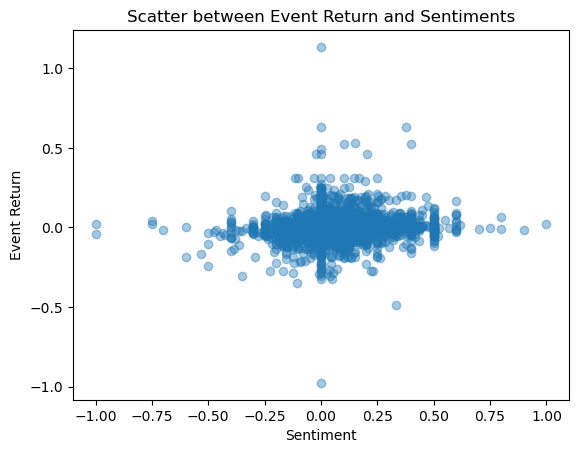

In [34]:
plt.scatter(df['sentiment_textblob'], df['eventRet'], alpha=0.4)
plt.title('Scatter between Event Return and Sentiments')
plt.ylabel('Event Return')
plt.xlabel('Sentiment')
plt.show()

In [35]:
corrlation = df['eventRet'].corr(df['sentiment_textblob'])
print(corrlation)

0.10669566753134241


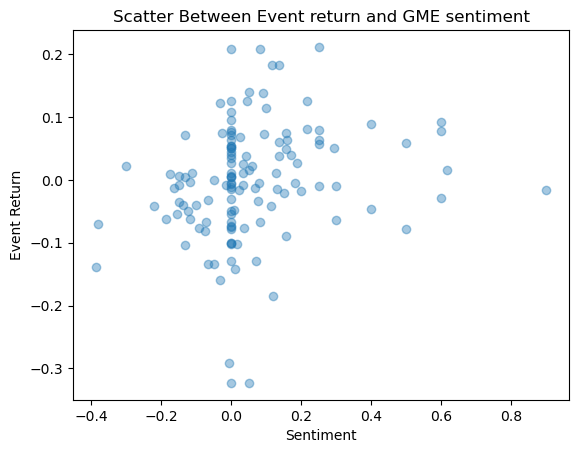

In [36]:
data_df_stock  = df[df['ticker'] == 'GME']
plt.scatter(data_df_stock['sentiment_textblob'],data_df_stock['eventRet'], alpha=0.4)
plt.title('Scatter Between Event return and GME sentiment')
plt.ylabel('Event Return')
plt.xlabel('Sentiment')
plt.show()

In [37]:
text_1 = df.headline.loc[1029]
text_1

"Former NHTSA Administrator David Strickland agrees with Tesla Motors (NASDAQ:TSLA) CEO Elon Musk that a distinction should be made about the automaker's so-called recall of the Model S."

In [38]:
TextBlob(text_1).sentiment_assessments

Sentiment(polarity=0.0, subjectivity=0.0, assessments=[(['former'], 0.0, 0.0, None)])

### Supervised Learning

In [39]:
sentiments_data = pd.read_csv(r'Data/LabelledNewsData.csv',encoding = "ISO-8859-1")

In [40]:
sentiments_data.head(1)

,datetime,headline,ticker,sentiment
0,1/16/2020 5:25,$MMM fell on hard times but could be set to re...,MMM,0


In [41]:
print(sentiments_data.shape[0],',', sentiments_data.ticker.unique().shape[0])

9470 , 30


Data has headlines for the news across 30 different stocks, with sentiments labelled 0 and 1.

In [42]:
all_vectors = pd.np.array([pd.np.array([token.vector for token in nlp(s) ]).mean(axis=0)*pd.np.ones((300)) \
                           for s in sentiments_data['headline']])

In [43]:
y= sentiments_data["sentiment"]
X = all_vectors

In [44]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [46]:
num_folds = 10
scoring = 'accuracy'

In [47]:
models = []
models.append(('LR', LogisticRegression(n_jobs=-1)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('NN', MLPClassifier()))
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
models.append(('RF', RandomForestClassifier(n_jobs=-1)))
models.append(('ETC', ExtraTreesClassifier()))
models.append(('SVC', SVC()))
models.append(('NB', GaussianNB()))

In [48]:
results = []
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    
    # Full train
    res = model.fit(X_train, y_train)
    train_result = accuracy_score(res.predict(X_train), y_train)
    train_results.append(train_result)

    # Test result
    test_result = accuracy_score(res.predict(X_train), y_train)
    test_results.append(test_result)

    msg = "%s: %f (%f) %f %f" % (name, cv_results.mean(), cv_results.std(), train_result, test_result)
    print(msg)
    print(confusion_matrix(res.predict(X_test), y_test))

LR: 0.874739 (0.010086) 0.894799 0.894799
[[660 110]
 [128 996]]
KNN: 0.768353 (0.016836) 0.851241 0.851241
[[552 206]
 [236 900]]
CART: 0.685855 (0.021812) 0.999868 0.999868
[[473 329]
 [315 777]]
LDA: 0.865365 (0.012399) 0.881996 0.881996
[[ 635  103]
 [ 153 1003]]
NN: 0.904567 (0.012889) 0.998812 0.998812
[[ 689   74]
 [  99 1032]]
AB: 0.730464 (0.020571) 0.765180 0.765180
[[492 240]
 [296 866]]
GBM: 0.773894 (0.016888) 0.855993 0.855993
[[509 163]
 [279 943]]
RF: 0.791848 (0.018120) 0.999868 0.999868
[[536 139]
 [252 967]]
ETC: 0.789602 (0.018785) 0.999868 0.999868
[[513 124]
 [275 982]]
SVC: 0.836061 (0.016820) 0.866684 0.866684
[[ 605  102]
 [ 183 1004]]
NB: 0.653645 (0.014330) 0.656679 0.656679
[[508 360]
 [280 746]]


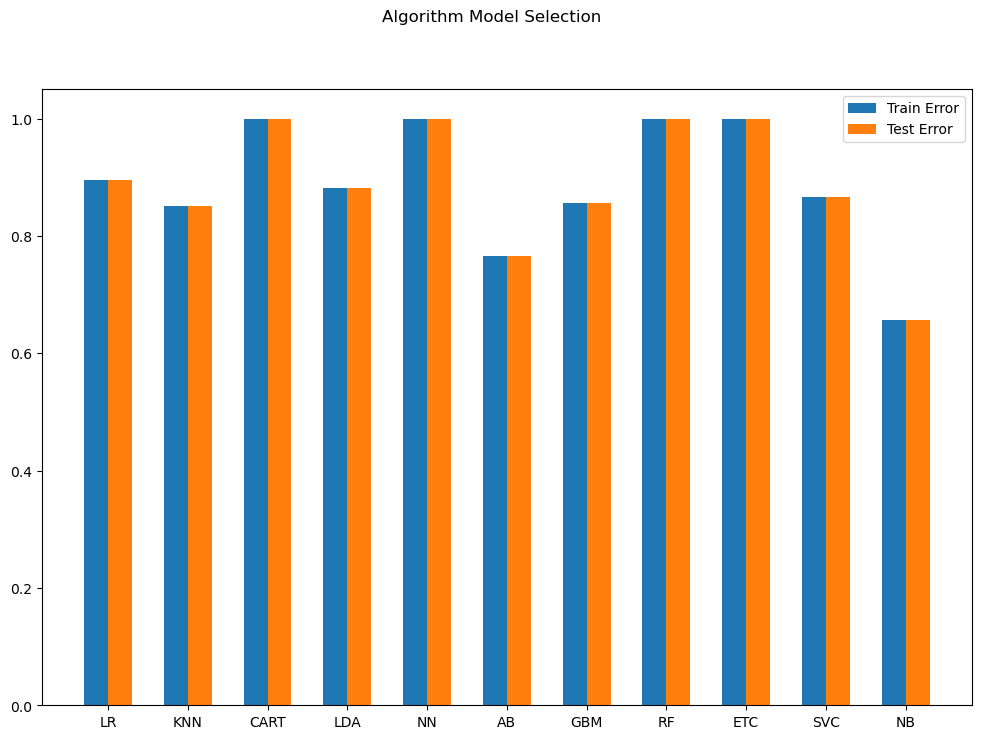

In [49]:
fig = plt.figure()
ind = np.arange(len(names))
fig.suptitle('Algorithm Model Selection')
ax = fig.add_subplot(111)
plt.bar(ind-0.3/2, train_results, width=0.3, label='Train Error')
plt.bar(ind+0.3/2, test_results, width=0.3, label='Test Error')
fig.set_size_inches(12,8)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.show()

In [50]:
pd.DataFrame({'Name':names, 'Train Result':train_results, 'Test Result':test_results
})

,Name,Train Result,Test Result
0,LR,0.894799,0.894799
1,KNN,0.851241,0.851241
2,CART,0.999868,0.999868
3,LDA,0.881996,0.881996
4,NN,0.998812,0.998812
5,AB,0.765180,0.765180
6,GBM,0.855993,0.855993
7,RF,0.999868,0.999868
8,ETC,0.999868,0.999868
9,SVC,0.866684,0.866684


Neural Network is best performer in terms of cross validation score, the training and testing accuracy is 99% on both. More overfitting for Decision Trees, Random Forest and Extra Tree. 

### LSTM

In [51]:
vocabulary_size = 20000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(sentiments_data['headline'])
sequences = tokenizer.texts_to_sequences(sentiments_data['headline'])
X_LSTM = pad_sequences(sequences, maxlen=50)

In [52]:
y_LSTM = sentiments_data["sentiment"]
X_train_LSTM, X_test_LSTM, Y_train_LSTM, Y_test_LSTM = train_test_split(X_LSTM, \
                       y_LSTM, test_size=0.3, random_state=42)

In [53]:
from keras.wrappers.scikit_learn import KerasClassifier
def create_model(input_length=50):
    model = Sequential()
    model.add(Embedding(20000, 300, input_length=50))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])    
    return model    
model_LSTM = KerasClassifier(build_fn=create_model, epochs=3, verbose=1, validation_split=0.4)
model_LSTM.fit(X_train_LSTM, Y_train_LSTM)

Epoch 1/3
125/125 [==============================] - 86s 655ms/step - loss: 0.4165 - accuracy: 0.8066 - val_loss: 0.1510 - val_accuracy: 0.9461
Epoch 2/3
125/125 [==============================] - 81s 647ms/step - loss: 0.0599 - accuracy: 0.9837 - val_loss: 0.0934 - val_accuracy: 0.9706
Epoch 3/3
125/125 [==============================] - 81s 649ms/step - loss: 0.0137 - accuracy: 0.9962 - val_loss: 0.0849 - val_accuracy: 0.9676


In [54]:
train_result_LSTM = accuracy_score(model_LSTM.predict(X_train_LSTM), Y_train_LSTM)
test_result_LSTM = accuracy_score(model_LSTM.predict(X_test_LSTM), Y_test_LSTM)

89/89 [==============================] - 7s 82ms/step


In [55]:
print(train_result_LSTM,test_result_LSTM)

0.9868758485442751 0.9598732840549102


In [56]:
train_results.append(train_result_LSTM)
test_results.append(test_result_LSTM)
names.append("LSTM")

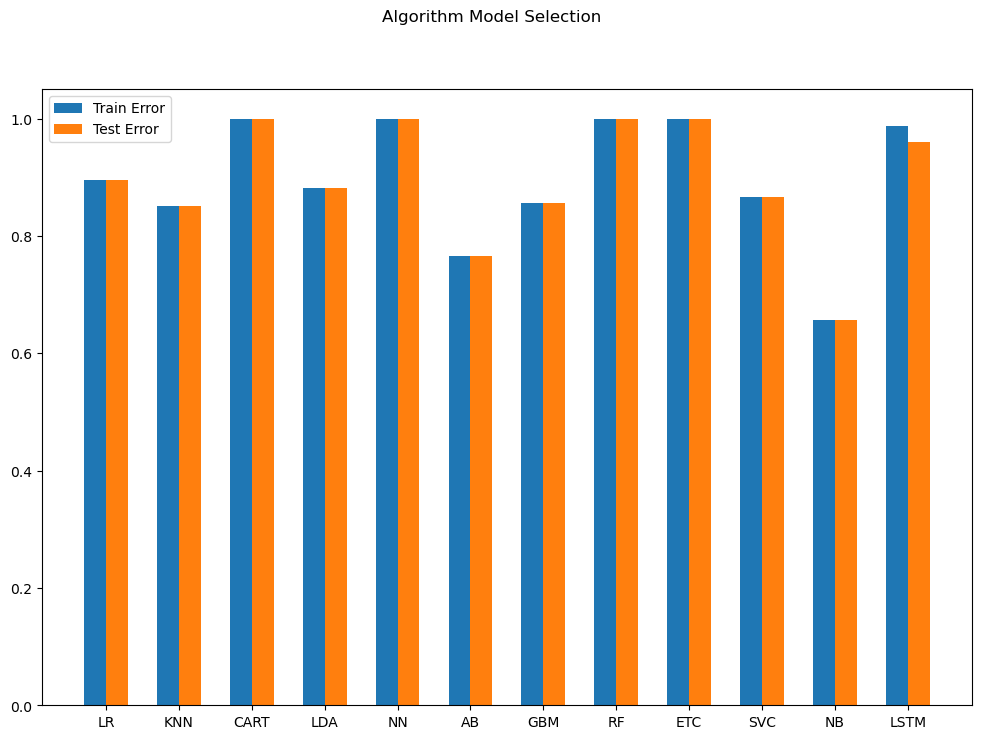

In [57]:
fig = plt.figure()
ind = np.arange(len(names))
fig.suptitle('Algorithm Model Selection')
ax = fig.add_subplot(111)
plt.bar(ind-0.3/2, train_results, width=0.3, label='Train Error')
plt.bar(ind+0.3/2, test_results, width=0.3, label='Test Error')
fig.set_size_inches(12,8)
plt.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.show()

Our loss for LSTM model has the best performance, along with NN. We also noticed that the other models were overfitted poorly and will exclude those in the model selection process.

In [58]:
sequences_LSTM = tokenizer.texts_to_sequences(df['headline'])
X_LSTM = pad_sequences(sequences_LSTM, maxlen=50)

In [59]:
Y_LSTM = model_LSTM.predict(X_LSTM)

95/95 [==============================] - 7s 76ms/step


In [60]:
df['sentiment_LSTM'] = Y_LSTM 

In [61]:
corrlation = df['eventRet'].corr(df['sentiment_LSTM'])
print(corrlation)

0.15322306921464338


In [62]:
df.head(10)

,ticker,headline,date,eventRet,Close,sentiment_textblob,sentiment_LSTM
0,AMZN,Whole Foods (WFMI) -5.2% following a downgrade...,2011-05-02,0.017650,10.059500,0.262500,0
1,NFLX,Netflix (NFLX +1.1%) shares post early gains a...,2011-05-02,-0.012912,33.884285,-0.043750,1
2,INTC,"For those seeking income in tech, don't just l...",2011-05-12,0.016662,16.680738,0.466667,1
3,AMZN,Amazon.com (AMZN -1.7%) shares slip as comment...,2011-05-12,-0.006607,10.303500,0.000000,0
4,GME,"Lots of good news for GameStop (GME +3%), and ...",2011-05-13,0.026523,4.497645,0.186667,1
5,INTC,Intel (INTC +1.4%) shares move higher as optio...,2011-05-16,-0.006635,16.631495,0.083333,1
6,GOOG,"It's been some time coming, but Google (GOOG -...",2011-05-16,-0.008073,12.912102,0.125000,1
7,AMZN,Amazon (AMZN -1.2%) moves nicely off its low f...,2011-05-23,-0.028021,9.811000,0.200000,0
8,JPM,The investigation by New York AG Eric Schneide...,2011-05-23,-0.038156,30.844414,0.136364,0
9,NFLX,Today's strength in Netflix (NFLX +4.8%) is at...,2011-05-25,0.063507,37.067142,0.013333,1


### Unsupervised Learning - Financial Lexicon

In [63]:
sia = SentimentIntensityAnalyzer()
stock_lex = pd.read_csv('data\LexiconData.csv')
stock_lex['sentiment'] = (stock_lex['Aff_Score'] + stock_lex['Neg_Score'])/2
stock_lex = dict(zip(stock_lex.Item, stock_lex.sentiment))
stock_lex = {k:v for k,v in stock_lex.items() if len(k.split(' '))==1}
stock_lex_scaled = {}
for k, v in stock_lex.items():
    if v > 0:
        stock_lex_scaled[k] = v / max(stock_lex.values()) * 4
    else:
        stock_lex_scaled[k] = v / min(stock_lex.values()) * -4

final_lex = {}
final_lex.update(stock_lex_scaled)
final_lex.update(sia.lexicon)
sia.lexicon = final_lex

example of extracting sentiment score for a sentence

In [64]:
text_1 = df.headline.loc[1029]

In [65]:
sia.polarity_scores(text_1)['compound']

0.4177

Extract sentiment for entire dataset

In [66]:
vader_sentiments = pd.np.array([sia.polarity_scores(s)['compound'] for s in df['headline']])
vader_sentiments.shape

(3015,)

In [217]:
df['sentiment_lex'] = vader_sentiments

In [218]:
corrlation = df['eventRet'].corr(df['sentiment_lex'])
print(corrlation)

0.20069867240675787


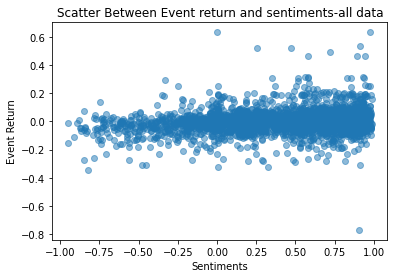

In [219]:
plt.scatter(df['sentiment_lex'],df['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-all data')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

We don't see many high returns for low sentiments, but data may not be clear

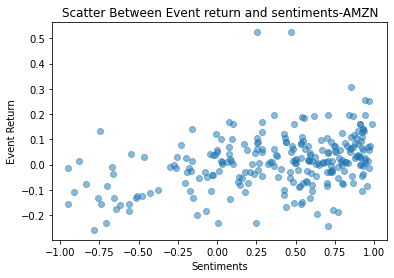

In [220]:
data_df_stock  = df[df['ticker'] == 'AMD']
plt.scatter(data_df_stock['sentiment_lex'],data_df_stock['eventRet'], alpha=0.5)
plt.title('Scatter Between Event return and sentiments-AMZN')
plt.ylabel('Event Return')
plt.xlabel('Sentiments')
plt.show()

Positive correlation between event return and sentiments

In [221]:
df.to_csv(r'Data\DataWithSentiments.csv', sep='|', index=False)

In [222]:
data_df = pd.read_csv(r'data\DataWithSentiments.csv', sep='|')
data_df = data_df[data_df['ticker'].isin(tickers)]

In [229]:
data_new_df_stock=data_df[data_df['ticker']== 'TSLA'][['ticker','headline','sentiment_textblob','sentiment_LSTM','sentiment_lex']]
from pandas import option_context

with option_context('display.max_colwidth', 400):
    display(data_new_df_stock.head(1))

,ticker,headline,sentiment_textblob,sentiment_LSTM,sentiment_lex
10,TSLA,"Tesla Motors (TSLA +3.6%) announces a follow-on offering of 5.3M shares, from which it will use funds to develop its Model X crossover electric vehicle. CEO Elon Musk will buy 1.5M shares in a concurrent offering.",0.0,1,0.7853


<AxesSubplot:title={'center':'Correlation Matrix'}>

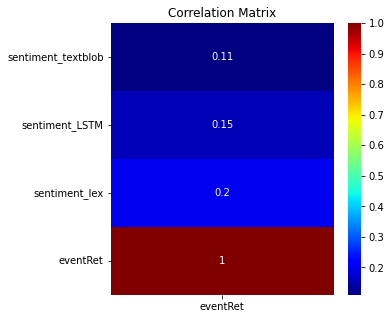

In [230]:
correlation = data_df[['sentiment_textblob','sentiment_LSTM','sentiment_lex','eventRet']].dropna(axis=0).corr()

plt.figure(figsize=(5,5))
plt.title('Correlation Matrix')
sns.heatmap(correlation[['eventRet']], vmax=1, annot=True,cmap='jet')

All the sentiment has a positive relationship with return

In [231]:
corr_data = []
for ticker in data_df['ticker'].unique():
    data_new_df_stock=data_df[data_df['ticker']==ticker]
    #Only look for the stocks with sufficient data
    if data_new_df_stock.shape[0] > 40 : 
        corr_textblob= data_new_df_stock['eventRet'].corr(data_new_df_stock['sentiment_textblob'])    
        corr_LSTM = data_new_df_stock['eventRet'].corr(data_new_df_stock['sentiment_LSTM'])
        corr_lex = data_new_df_stock['eventRet'].corr(data_new_df_stock['sentiment_lex'])
        corr_data.append([ticker,corr_textblob, corr_LSTM, corr_lex])
        #print(ticker,corr_vader, corr_LSTM, corr_textblob)
    else:
        continue

In [234]:
corr_df = pd.DataFrame(corr_data, columns =  ['ticker','corr_textblob','corr_LSTM','corr_lex'])  
corr_df=corr_df.set_index('ticker')
corr_df.head(5)

,corr_textblob,corr_LSTM,corr_lex
ticker,,,
AMZN,0.018636,0.184621,0.126934
NFLX,0.104197,0.158930,0.221759
INTC,0.095391,0.206704,0.180704
GME,0.221272,0.281122,0.123782
GOOG,0.016635,0.201018,0.209936


In [236]:
corr_df.columns

Index(['corr_textblob', 'corr_LSTM', 'corr_lex'], dtype='object')

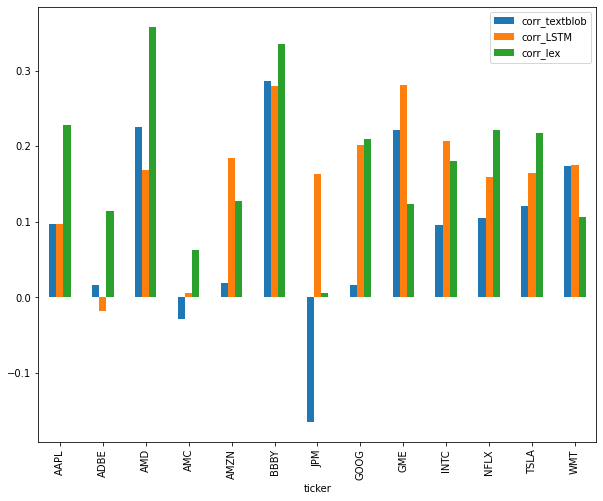

In [238]:
corr_df.loc[tickers].plot.bar(figsize = (10,8))
plt.show()

The correlation from the lexicon method is highest across all the securities, which corraborates the conclusion from previous analysis

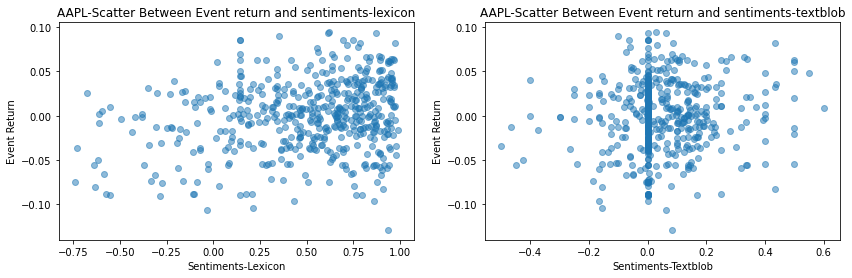

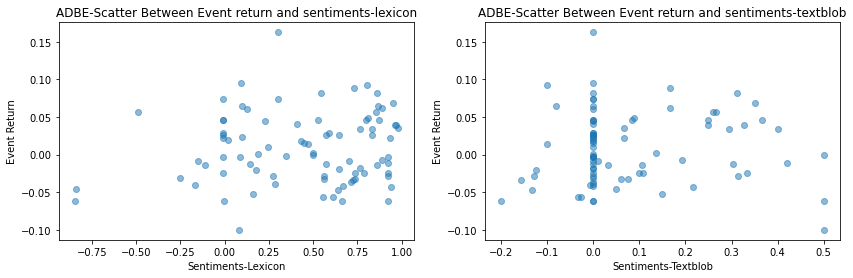

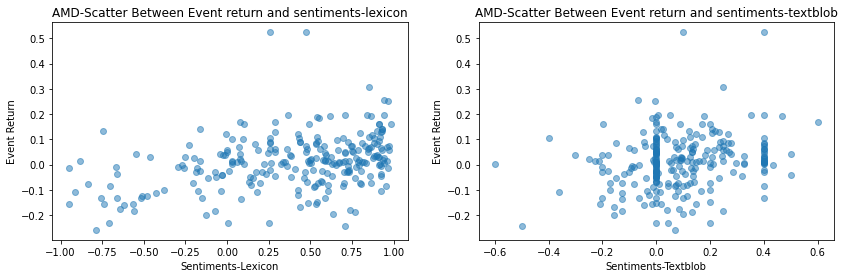

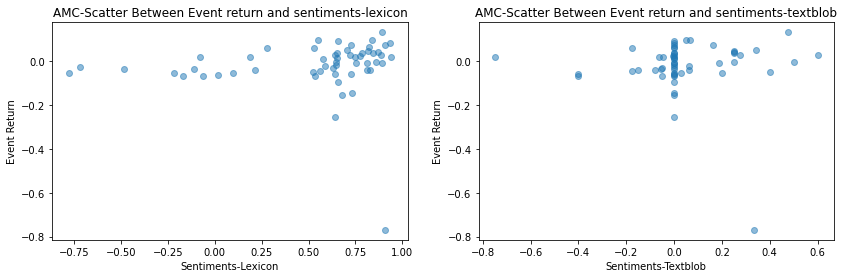

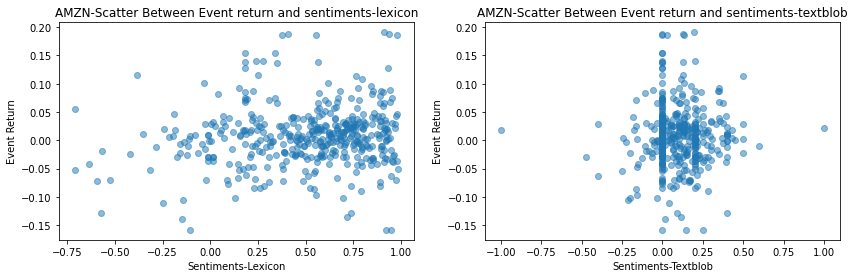

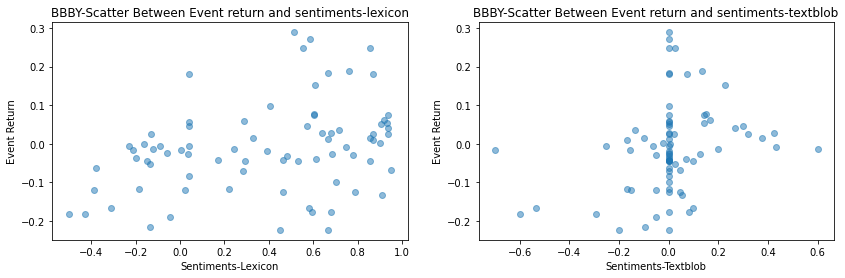

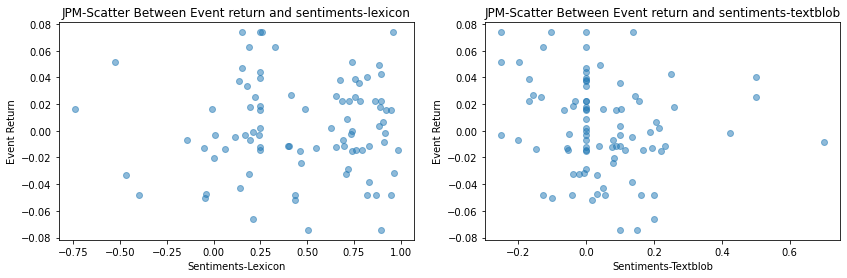

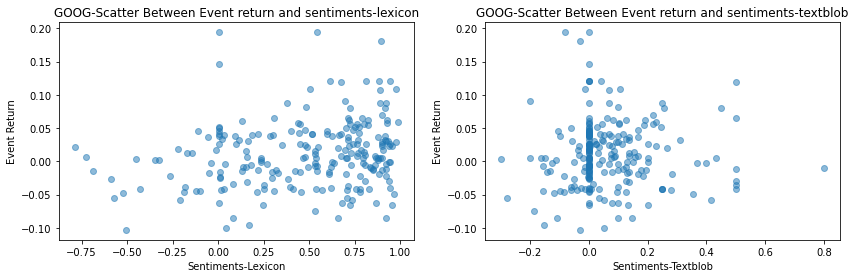

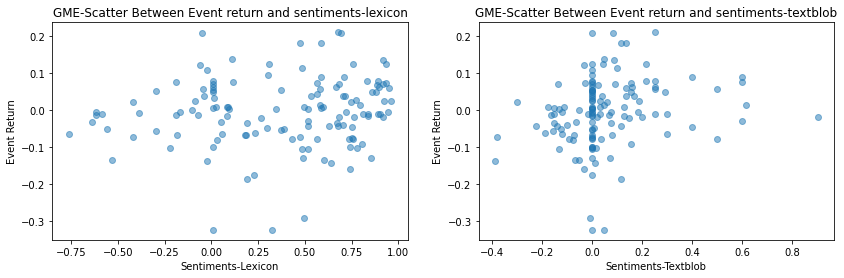

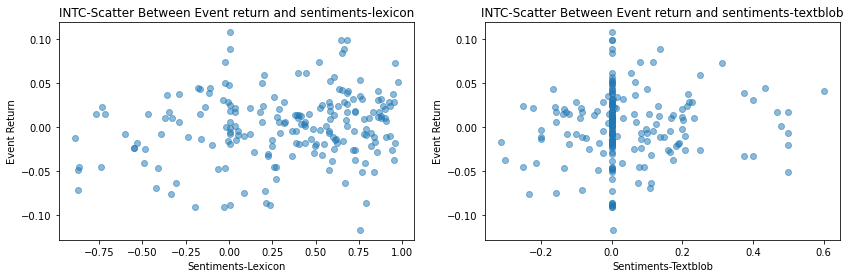

In [245]:
for ticker in tickers[:10]:
    data_df_stock  = data_df[data_df['ticker'] == ticker]
    fig = plt.figure(figsize=(14, 4), constrained_layout=False)

    plt.subplot(1, 2, 1)
    plt.scatter(data_df_stock['sentiment_lex'],data_df_stock['eventRet'], alpha=0.5)
    plt.title(ticker + '-Scatter Between Event return and sentiments-lexicon')
    plt.ylabel('Event Return')
    plt.xlabel('Sentiments-Lexicon')

    plt.subplot(1, 2, 2)
    plt.scatter(data_df_stock['sentiment_textblob'],data_df_stock['eventRet'], alpha=0.5)
    plt.title(ticker + '-Scatter Between Event return and sentiments-textblob')
    plt.ylabel('Event Return')
    plt.xlabel('Sentiments-Textblob')
    plt.show()

Lexicon based sentiments on the left definiteyl shows a positive relationship between sentiments and returns. We proceed with lexicon based sentiment for trading strategy

### Building the Trading Strategy (Model Evaluation)

Sentiment data can be used in a separate way from the trading AI. Sentiment scores can be used as a signaling factor and ideally create a long-short portfolio, by buying the stocks with positive scores and selling stocks with negative scores. They can also be used as additional features over and above other features (correlated stocks, technical indicators) in a supervised learning model to predict the price or come up with a trading strategy)

For this project, we buy and sell stock as per the currernt stock sentiments
* Buy a stock when change in sentiment score (current sentiment score - previous sentiment score) is > than 0.5 and sell the stock when the difference is < 0.5.
* Check 15 days moving average while buying and selling and buy/sell in unit of 100

We use backtrader, a Python based API for backtesting and writing trading strategy. It allows us to focus on writing reusable trading strategies, indicators, and analyzers instead of having to spend time building infrastructure. \
https://www.backtrader.com/docu/quickstart/quickstart/ 

We impliment a simple strategy to buy if previous day's sentiment score increases by 0.5 from the last day and sell if it decreases by 0.5. Two classes:
* Sentiment:
* SentimentStrat: The 'next' function of this class implements the actual trading strategy



In [246]:
import backtrader as bt
import backtrader.indicators as btind
import backtrader.analyzers as btanalyzers

In [247]:
class Sentiment(bt.Indicator):
    lines = ('sentiment',)
    plotinfo = dict(
        plotymargin=0.5,
        plothlines=[0],
        plotyticks=[1.0, 0, -1.0])
    
    def next(self):
        self.sentiment = 0.0
        self.date = self.data.datetime
        date = bt.num2date(self.date[0]).date()
        prev_sentiment = self.sentiment        
        if date in date_sentiment:
            self.sentiment = date_sentiment[date]
        self.lines.sentiment[0] = self.sentiment


In [274]:
class SentimentStrat(bt.Strategy):
    params = (
        ('period', 15),
        ('printlog', True),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function for this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # Keep track of pending orders
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.period)
        self.date = self.data.datetime
        self.sentiment = None
        Sentiment(self.data)
        self.plotinfo.plot = False
        
        
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return
        
        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:  # Sell
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                         (order.executed.price,
                          order.executed.value,
                          order.executed.comm))
                
            self.bar_executed = len(self)     
            
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            
        # Write down: no pending order
        self.order = None
        
    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
    
    ### Main Strat ###
    def next(self):        
        date = bt.num2date(self.date[0]).date()
        prev_sentiment = self.sentiment
        if date in date_sentiment:
            self.sentiment = date_sentiment[date]
        
        # Check if an order is pending. if yes, we cannot send a 2nd one
        if self.order:
            return       
        # If not in the market and previous sentiment not none
        if not self.position and prev_sentiment:
            # buy if current close more than sma AND sentiment increased by >= 0.5
            if self.dataclose[0] > self.sma[0] and self.sentiment - prev_sentiment >= 0.5:
                self.log('Previous Sentiment %.2f, New Sentiment %.2f BUY CREATE, %.2f' % (prev_sentiment, self.sentiment, self.dataclose[0]))                
                self.order = self.buy()
                
        # Already in the market and previous sentiment not none
        elif prev_sentiment:
            # sell if current close less than sma AND sentiment decreased by >= 0.5
            if self.dataclose[0] < self.sma[0] and self.sentiment - prev_sentiment <= -0.5:
                self.log('Previous Sentiment %.2f, New Sentiment %.2f SELL CREATE, %.2f' % (prev_sentiment, self.sentiment, self.dataclose[0]))                
                self.order = self.sell()

    def stop(self):
        self.log('(MA Period %2d) Ending Value %.2f' %
                 (self.params.period, self.broker.getvalue()), doprint=True)   


In [275]:
def run_strategy(ticker, start, end):
    print(ticker)    
    ticker = yf.Ticker(ticker)
    df_ticker = ticker.history(start = start, end = end)
    
    cerebro = bt.Cerebro()
    # Add the data
    cerebro.addstrategy(SentimentStrat)        
    data = bt.feeds.PandasData(dataname=df_ticker)
    cerebro.adddata(data)    
    start = 100000.0
    cerebro.broker.setcash(start)   
    cerebro.addsizer(bt.sizers.FixedSize, stake=100)
    print('Starting Portfolio Value: %.2f' % start)    
    plt.rcParams['figure.figsize']=[10,6]
    plt.rcParams["font.size"]="12"
    cerebro.run() 
    cerebro.plot(volume=False, iplot=True, plotname= ticker)
    end = cerebro.broker.getvalue()
    print('Start Portfolio value: %.2f\nFinal Portfolio Value: %.2f\nProfit: %.2f\n' \
          % (start, end, end - start))
    return float(df_ticker['Close'][0]), (end - start)

TSLA
Starting Portfolio Value: 100000.00
2012-03-26, Previous Sentiment 0.30, New Sentiment 0.90 BUY CREATE, 2.49
2012-03-27, BUY EXECUTED, Price: 2.48, Cost: 247.73, Comm 0.00
2012-09-10, Previous Sentiment 0.89, New Sentiment -0.33 SELL CREATE, 1.82
2012-09-11, SELL EXECUTED, Price: 1.85, Cost: 247.73, Comm 0.00
2012-09-11, OPERATION PROFIT, GROSS -62.67, NET -62.67
2012-12-04, Previous Sentiment 0.22, New Sentiment 0.76 BUY CREATE, 2.26
2012-12-05, BUY EXECUTED, Price: 2.25, Cost: 225.47, Comm 0.00
2013-02-21, Previous Sentiment 0.87, New Sentiment 0.04 SELL CREATE, 2.34
2013-02-22, SELL EXECUTED, Price: 2.38, Cost: 225.47, Comm 0.00
2013-02-22, OPERATION PROFIT, GROSS 12.67, NET 12.67
2013-03-25, Previous Sentiment 0.32, New Sentiment 0.87 BUY CREATE, 2.50
2013-03-26, BUY EXECUTED, Price: 2.53, Cost: 253.20, Comm 0.00
2013-09-12, Previous Sentiment 0.94, New Sentiment 0.28 SELL CREATE, 11.00
2013-09-13, SELL EXECUTED, Price: 10.85, Cost: 253.20, Comm 0.00
2013-09-13, OPERATION PROF

<IPython.core.display.Javascript object>

Start Portfolio value: 100000.00
Final Portfolio Value: 101050.33
Profit: 1050.33



(1.871999979019165, 1050.3332614898682)

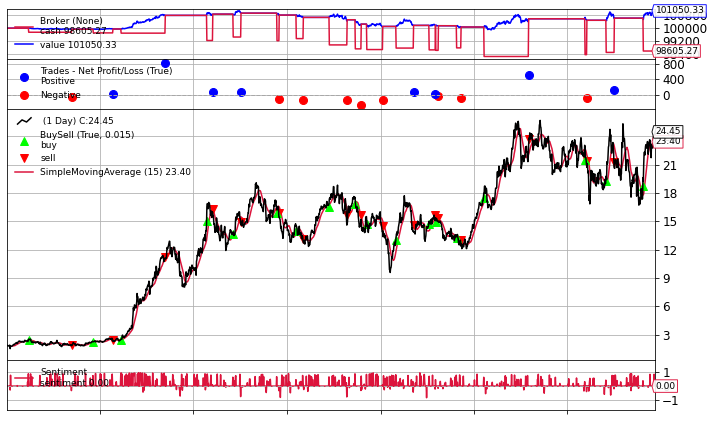

In [276]:
ticker = 'TSLA'
date_sentiment=data_df[data_df['ticker'].isin([ticker])]
date_sentiment=date_sentiment[['date','sentiment_lex']]
date_sentiment['date']=pd.to_datetime(date_sentiment['date'], format='%Y-%m-%d').dt.date
date_sentiment=date_sentiment.set_index('date')['sentiment_lex']
date_sentiment=date_sentiment.to_dict()
run_strategy(ticker, start = '2012-01-01', end = '2018-12-12')

Not bad for only 1 source of media. With this NLP strategy, I can impliment a two-factor validation for a buy/sell signal instaed of relying on forecasting